*  CLASSES = 4
*   MODEL = VGG19

*  ACTIVATION FUNCTION = ReLU

* OUTPUTFUNCTION = SOFTMAX


*   LOSS FUNCTION = CATOGIRICAL CROSS ENTROPY






In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing import image


#from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import VGG19
from keras.applications.mobilenet import preprocess_input
import numpy as np
from IPython.display import Image

In [ ]:

from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
#tf.enable_eager_execution()

import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import matplotlib.pyplot as plt
#from keras import optimizers

In [ ]:
import os
img_path = os.getcwd() + r'/images'
print(img_path)

/content/images


In [ ]:
base_dir = os.getcwd()+r'/content/drive/MyDrive/RLD_updated'
train_dir = os.path.join('/content/drive/MyDrive/RLD_updated/Train')
validation_dir = os.path.join('/content/drive/MyDrive/RLD_updated/Val')
test_dir = os.path.join('/content/drive/MyDrive/RLD_updated/Test')

train_Blast_dir = os.path.join(train_dir, 'Blast')
train_Blight_dir = os.path.join(train_dir, 'Blight')
train_Brownspot_dir = os.path.join(train_dir, 'Brownspot')
train_Tungro_dir = os.path.join(train_dir, 'Tungro')


validation_Blast_dir = os.path.join(validation_dir, 'Blast')
validation_Blight_dir = os.path.join(validation_dir, 'Blight')
validation_Brownspot_dir = os.path.join(validation_dir, 'Brownspot')
validation_Tungro_dir = os.path.join(validation_dir, 'Tungro')







NUMBER_OF_CLASS = 4

In [ ]:
IMAGE_SIZE = (224, 224)
def prepare_image(file):
    img = image.load_img(file, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [ ]:
from keras.preprocessing import image
def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])
        plt.axis('off')
        plt.show()

    return img_tensor

In [ ]:
IMAGE_SIZE = (224, 224)
def prepare_image(file):
    img = image.load_img(file, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobislenet.preprocess_input(img_array_expanded_dims)

In [ ]:
#imports the mobilenet model and discards the last 1000 neuron layer.
base_model=VGG19(weights='imagenet',include_top=False, input_shape=(224,224,3))



80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
#base_model.summary()

In [ ]:
x= Flatten()(base_model.output)

x=  Dense(units = 4, activation = 'softmax')(x)

#creating model
model = Model(base_model.input, x)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

early stopping

In [ ]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 3, verbose =1)

mc = ModelCheckpoint(filepath = "/content/drive/MyDrive/vgg_weights/vgg19_weights.h5",   #best_model.h5
                      moniter = 'val_accuracy',
                      min_delta = 0.01,
                      patience = 3,
                      verbose= 1,
                      save_best_only = True)

cb = [es, mc]

In [ ]:
BATCH_SIZE = 32

# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30, ###40,
    width_shift_range=0.1, ###0.2,
    height_shift_range=0.1, ###0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the val data should not be augmented!
test_datagen= ImageDataGenerator    (rescale=1./255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical',
        shuffle=True)

# Flow validation images in batches using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True)

Found 4772 images belonging to 4 classes.
Found 584 images belonging to 4 classes.


In [ ]:
his = model.fit_generator(train_generator,
                          steps_per_epoch = 16,
                          epochs = 10,
                          verbose =1,
                          callbacks = cb,
                          validation_data = validation_generator,
                          validation_steps = 16)

<ipython-input-18-12ca4646da0a>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  his = model.fit_generator(train_generator,


Epoch 1/10
16/16 [==============================] - ETA: 0s - loss: 1.7711 - accuracy: 0.4590
Epoch 1: val_loss improved from inf to 1.01324, saving model to /content/drive/MyDrive/vgg_weights/vgg19_weights.h5
16/16 [==============================] - 227s 13s/step - loss: 1.7711 - accuracy: 0.4590 - val_loss: 1.0132 - val_accuracy: 0.6152
Epoch 2/10
16/16 [==============================] - ETA: 0s - loss: 0.9265 - accuracy: 0.6562
Epoch 2: val_loss improved from 1.01324 to 0.65158, saving model to /content/drive/MyDrive/vgg_weights/vgg19_weights.h5
16/16 [==============================] - 91s 6s/step - loss: 0.9265 - accuracy: 0.6562 - val_loss: 0.6516 - val_accuracy: 0.7559
Epoch 3/10
16/16 [==============================] - ETA: 0s - loss: 0.6046 - accuracy: 0.7754
Epoch 3: val_loss improved from 0.65158 to 0.57167, saving model to /content/drive/MyDrive/vgg_weights/vgg19_weights.h5
16/16 [==============================] - 75s 5s/step - loss: 0.6046 - accuracy: 0.7754 - val_loss: 0.5

In [ ]:
h = his.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracay'])

NameError: ignored

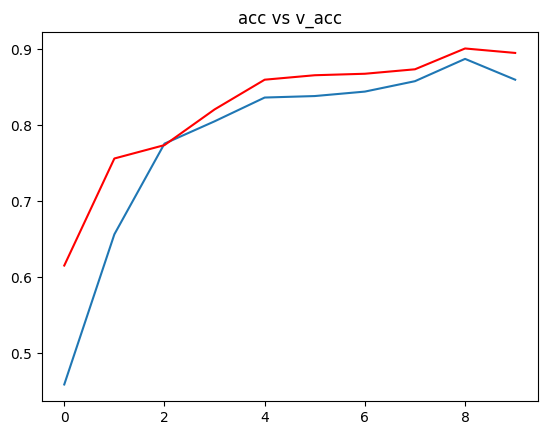

In [ ]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c = 'red')
plt.title("acc vs v_acc")
plt.show()

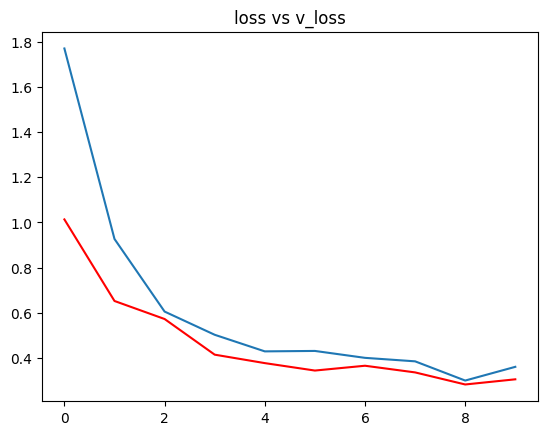

In [ ]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c = 'red')
plt.title("loss vs v_loss")
plt.show()

In [ ]:
#load best model

from keras.models import load_model

model = load_model("/content/drive/MyDrive/vgg_weights/vgg19_weights.h5")  #/content/best_model.h5

In [ ]:
acc = model.evaluate_generator(validation_generator)[1]

print(f"the accuracy of model is = {acc*100}%")

<ipython-input-23-15e8458f0d76>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc = model.evaluate_generator(validation_generator)[1]


the accuracy of model is = 90.75342416763306%


In [ ]:
import glob
list_of_files = glob.glob(test_dir+'/*.jpg')           # create the list of file from test directory
print(len(list_of_files))
print(test_dir)

0
/content/drive/MyDrive/RLD_updated/Test


In [ ]:
class_names=['Blast', 'Blight' , 'Brownspot' , 'Tungro']

In [ ]:
# Randomly choose a picture to test your model
import matplotlib.pyplot as plt

img_number= int(np.random.randint(0,len(list_of_files), size=1))
test_image=list_of_files[img_number]

new_image = load_img(test_image)
new_image = new_image.resize((224, 224))
#new_image = Image.open(test_image)
#new_image = plt.imread(test_image)
img_array = img_to_array(new_image)
img_batch = np.expand_dims(img_array, axis=0)
pred = model.predict(img_batch)
print(pred[0])
prediction_result = class_names[np.argmax(pred[0])]
print('prediction=',prediction_result)

#img = image.load_img(test_image,target_size=IMAGE_SIZE)

plt.imshow(new_image)

ValueError: ignored

In [ ]:
train_path = '/content/drive/MyDrive/RLD_updated/Train'
test_path = '/content/drive/MyDrive/RLD_updated/Test'
IMG_BREDTH = 224
IMG_HEIGHT = 224
num_classes = 4







train_batch = ImageDataGenerator(featurewise_center=False,
                                 samplewise_center=False,
                                 featurewise_std_normalization=False,
                                 samplewise_std_normalization=False,
                                 zca_whitening=False,
                                 rotation_range=45,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 horizontal_flip=True,
                                 vertical_flip=False).flow_from_directory(train_path,
                                                                          target_size=(IMG_HEIGHT, IMG_BREDTH),
                                                                          classes=['Blast', 'Blight', 'Brownspot', 'Tungro'],
                                                                          batch_size=100)

test_batch = ImageDataGenerator().flow_from_directory(test_path,
                                                      target_size=(IMG_HEIGHT, IMG_BREDTH),
                                                      classes=['Blast', 'Blight', 'Brownspot', 'Tungro'],
                                                      batch_size=100)

Found 4772 images belonging to 4 classes.
Found 576 images belonging to 4 classes.


In [ ]:
import sklearn.metrics as metrics # classification_report, confusion_matrix
batch_size = 100
target_names = ['Blast', 'Blight', 'Brownspot', 'Tungro']
Y_pred = model.predict_generator(test_batch, 576 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = metrics.confusion_matrix(test_batch.classes, y_pred)
print(cm)
print('Classification Report')
#print(metrics.classification_report(test_batch.classes, y_pred))

<ipython-input-34-b5b9c36a539d>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_batch, 576 // batch_size+1)


Confusion Matrix
[[41 31 31 49]
 [31 23 39 63]
 [23 27 34 60]
 [21 27 29 47]]
Classification Report


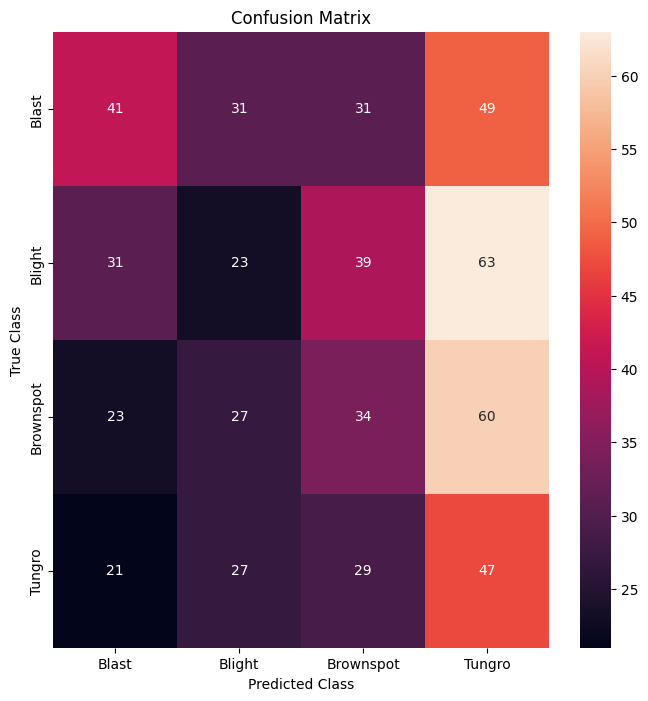

In [ ]:
import seaborn as sns
import sklearn.metrics as metrics
# To print the Confusion Matrix
cf_matrix = metrics.confusion_matrix(test_batch.classes, y_pred)
Labels = ['Blast', 'Blight', 'Brownspot', 'Tungro']
plt.figure(figsize=(8, 8))
heatmap = sns.heatmap(cf_matrix, xticklabels=Labels, yticklabels=Labels, annot=True, fmt='d', color='blue')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(test_batch)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(test_batch.classes, y_pred))

6/6 [==============================] - 3s 486ms/step
              precision    recall  f1-score   support

           0       0.28      0.22      0.25       152
           1       0.30      0.21      0.24       156
           2       0.23      0.22      0.22       144
           3       0.20      0.35      0.26       124

    accuracy                           0.24       576
   macro avg       0.25      0.25      0.24       576
weighted avg       0.26      0.24      0.24       576



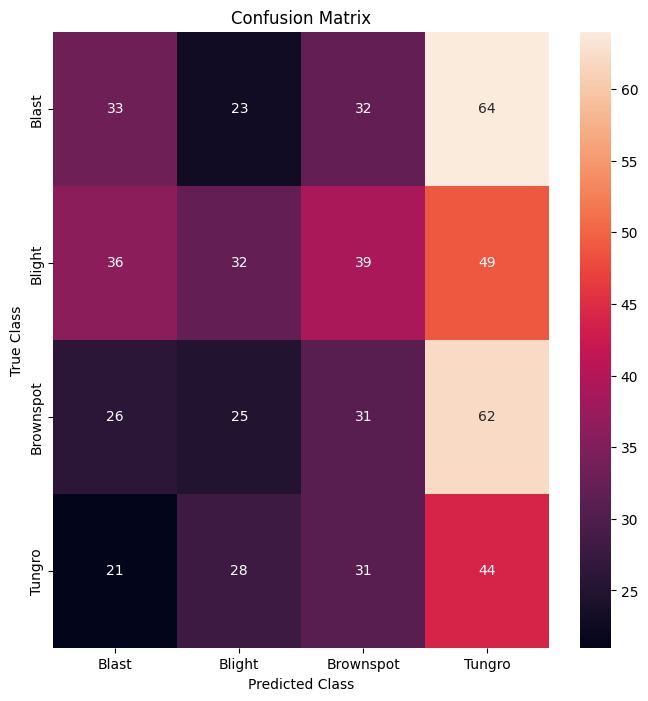

In [ ]:
# To print the Confusion Matrix
cf_matrix = confusion_matrix(test_batch.classes, y_pred)
Labels = ['Blast', 'Blight', 'Brownspot', 'Tungro']
plt.figure(figsize=(8, 8))
heatmap = sns.heatmap(cf_matrix, xticklabels=Labels, yticklabels=Labels, annot=True, fmt='d', color='blue')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()